In [4]:
import json
import pandas as pd
import numpy as np  
import os
import random

from metric import r_precision, dcg_at_k, ndcg_at_k
from utils import generate_playlists, generate_testcases

from numpy import linalg as LA

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import collections

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
path_to_data = '../../data' #'/content/drive/MyDrive/DO_AN_KHDL/DATA'
path_audio_feats = os.path.join(path_to_data, 'audio_features.tsv')
path_playlists = os.path.join(path_to_data, 'playlists.tsv')
path_tracks = os.path.join(path_to_data, 'tracks.tsv')

In [6]:
pd_audio_feats = pd.read_csv(path_audio_feats, sep = '\t')
pd_tracks = pd.read_csv(path_tracks, sep = '\t')
pd_playlists = pd.read_csv(path_playlists, sep = '\t')
pd_playlists = pd_playlists.fillna('None')

In [7]:
pd_tracks = pd.merge(pd_tracks, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_full = pd.merge(pd_tracks, pd_playlists, left_on = 'playlist_id', right_on = 'playlist_id')

pd_tracks = pd_tracks.drop('id', 1)
pd_full = pd_full.drop('playlist_name_y', 1)
pd_full = pd_full.drop('id', 1)

In [8]:
pd_full.shape

(86400, 27)

In [9]:
#Thông tin rỗng là discription, ta có thể chỉ điền vào "None"
pd_full = pd_full.fillna('None')

In [10]:
#Kiểm tra và bỏ giá trị trùng lặp
pd_full = pd_full.drop_duplicates()

In [11]:
pd_full['available_markets'] = pd_full['available_markets'].apply(lambda x : x[1:-1].split(', '))
pd_full['count_available_markets'] = pd_full['available_markets'].apply(lambda x : len(x))

In [12]:
pd_full.shape

(86350, 28)

## Baseline model

* **Thuộc tính**: dựa vào kết quả EDA, sử dụng 5 thuộc tính có phân phối gần chuẩn nhất bao gồm `danceability`, `energy`, `acousticness`, `valence`, `popularity`.
* **Mô tả ý tưởng**:
    * Tính **K** tracks trong tập hợp tất cả các tracks (trừ những seed tracks) có khoảng cách L2 gần nhất với từng seed track, ta được tập **N x K** tracks.
    * Sort các tracks vừa tìm được theo tần suất xuất hiện và chọn **K** tracks xuất hiện nhiều nhất làm kết quả dự đoán.

### thử sử dụng duy nhất một đặc trưng 'danceability'

#### create test-cases

In [15]:
fraction = 3
track_id_all = generate_playlists(pd_tracks, pd_playlists)
track_id_test = generate_testcases(track_id_all, fraction = fraction)

In [16]:
all_playlistID_for_tests = list(track_id_test.keys())

In [17]:
pd_full_tests = pd_full.copy()
pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]

#### modeling

In [18]:
def baseline(tracks, df, n_pred):
    recs_id = []
    for t in tracks:
        danceability = df[df['track_id'] == t]['danceability']
        df['rec_df_dance'] = np.abs(df['danceability'] - danceability.values[0])
        one_recs_id = list(df.sort_values(by=['rec_df_dance'])['track_id'][1:].values)
        recs_id.extend([track for track in one_recs_id if track not in tracks][0:n_pred])

    preds = collections.Counter(recs_id).most_common(n_pred)
    pred_titles = [p[0] for p in preds]

    tracks_name = []
    for id_track in pred_titles:
      tracks_name.extend(list(np.unique(df[df['track_id'] == id_track]['track_name'].values)))

    return pred_titles, tracks_name

#### testing

**Bây giờ ta sẽ thử test phương pháp này trên playlist đầu tiên của tập test**

In [19]:
playlists_to_test = all_playlistID_for_tests[0]

In [20]:
all_name_songs = list(pd_full[pd_full['track_id'].isin(track_id_all[playlists_to_test])]['track_name'].values)
given_songs_name = list(pd_full[pd_full['track_id'].isin(track_id_test[playlists_to_test])]['track_name'].values)

In [21]:
track_id_result, track_name_result = baseline(track_id_test[playlists_to_test], pd_full_tests, len(track_id_all[playlists_to_test])-len(track_id_test[playlists_to_test]))

In [22]:
print('Songs given: ', given_songs_name, '\n')
print('Songs recommended: ', track_name_result, '\n')

Songs given:  ['Falling Short', 'Falling Short', 'Falling Short', 'Chill', 'Middle', 'Mood Ring', 'On Circus', 'Night Lake', 'Busy', 'Memory Lane', 'Need To Breathe', 'Call Me', 'Feeling Forever - Bondax Remix', 'lyfe tajm', 'Bingsoo', 'Tomorrow', 'Too Tired', 'Save Me', 'Wish We Had History', 'Parting Ways - Sigh-Phy Remix', 'Bittersweetener', 'Rays', 'Rural', 'Melting Sun', 'Spinning (feat. Ilsey)', 'Świnoujście'] 

Songs recommended:  ['positions', 'Chapter 32', 'SO DONE', 'William Wordsworth: I Wandered Lonely As a Cloud', 'Read My Thoughts', 'Do I Do', 'Hearts', 'The Crime At Pickets Mill', 'Time of Our Lives', 'Samson and Delilah', 'Virtue', 'Aurora Leigh (Excerpts) - Elizabeth Barrett Browning', 'Glitch Through the Matrix', 'BEN AFFLECK', 'Du som snodde min cykel', 'Right Round', 'Pebble', 'Chapter 16', 'Treat Yo Self', 'Diamonds', 'Compass', 'Rob Roy: Chapter 4, An Encounter', 'Last Christmas', 'On The Floor - Radio Edit', 'Surrounded by Bubbles', 'Be With You', 'Moves Like J

**Bây giờ ta sẽ sử dụng tất cả 100 playlists trong bộ test để đánh giá**

In [28]:
def test_multi_feats(pd_playlists, pd_full, fraction = 5, nums_playlists_test = 100):
  r_score = []

  track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
  track_id_test = generate_testcases(track_id_all, fraction = fraction)

  all_playlistID_for_tests = list(track_id_test.keys())

  pd_full_tests = pd_full.copy()
  pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
  pd_full_tests = pd_full_tests.reset_index(drop = True)

  for each_playlist in all_playlistID_for_tests:
    track_id_result, track_name_result = baseline(track_id_test[each_playlist], pd_full_tests, len(track_id_all[each_playlist])-len(track_id_test[each_playlist]))
    
    all_name_songs = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_all[each_playlist])]['track_name'].values)
    given_songs_name = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_test[each_playlist])]['track_name'].values) 
    test_songs_name = [x for x in all_name_songs if x not in given_songs_name]

    r_score.append(r_precision(track_name_result, test_songs_name))

  return r_score

In [29]:
r_score = test_multi_feats(pd_playlists, pd_full, fraction = 5, nums_playlists_test = 100)

print("Average R precision: " + str(np.mean(r_score)))
print("Max R precision: " + str(np.max(r_score)))

Average R precision: 0.02930887770432027
Max R precision: 0.23333333333333334


### Sử dụng multi features thay vì một feature (`danceability`, `energy`, `acousticness`, `valence`, `popularity`)

#### modeling

In [30]:
features = ['danceability', 'energy', 'acousticness', 'valence', 'popularity']

In [31]:
def multi_feats_baseline(tracks, df, n_pred, feats):
    recs_id = []
    for t in tracks:
      sum_feat_values = 0
      for feat in feats:
        feat_values = df[df['track_id'] == t][feat]
        sum_feat_values = sum_feat_values + np.abs(df[feat] - feat_values.values[0]) ** 2
      
      df['rec_df_feats'] = sum_feat_values ** (1/2)
      one_recs_id = list(df.sort_values(by=['rec_df_feats'])['track_id'][1:].values)
      recs_id.extend([track for track in one_recs_id if track not in tracks][0:n_pred])

    preds = collections.Counter(recs_id).most_common(n_pred)
    pred_titles = [p[0] for p in preds]

    tracks_name = []
    for id_track in pred_titles:
      tracks_name.extend(list(np.unique(df[df['track_id'] == id_track]['track_name'].values)))

    return pred_titles, tracks_name

#### testing

**Bây giờ ta sẽ thử test phương pháp này trên playlist đầu tiên của tập test**

In [41]:
playlists_to_test = all_playlistID_for_tests[0]

In [42]:
all_name_songs = list(pd_full[pd_full['track_id'].isin(track_id_all[playlists_to_test])]['track_name'].values)
given_songs_name = list(pd_full[pd_full['track_id'].isin(track_id_test[playlists_to_test])]['track_name'].values)

In [43]:
track_id_result, track_name_result = multi_feats_baseline(track_id_test[playlists_to_test], pd_full_tests, len(track_id_all[playlists_to_test])-len(track_id_test[playlists_to_test]), features)

In [44]:
print('Songs given: ', given_songs_name, '\n')
print('Songs recommended: ', track_name_result, '\n')

Songs given:  ['Falling Short', 'Falling Short', 'Falling Short', 'Chill', 'Middle', 'Mood Ring', 'On Circus', 'Night Lake', 'Busy', 'Memory Lane', 'Need To Breathe', 'Call Me', 'Feeling Forever - Bondax Remix', 'lyfe tajm', 'Bingsoo', 'Tomorrow', 'Too Tired', 'Save Me', 'Wish We Had History', 'Parting Ways - Sigh-Phy Remix', 'Bittersweetener', 'Rays', 'Rural', 'Melting Sun', 'Spinning (feat. Ilsey)', 'Świnoujście'] 

Songs recommended:  ['Both Of Us - Jayda G Sunset Bliss Mix', 'Clouds', 'The Recipe (prod. by KAYTRANADA) - The Martinez Brothers Remix', "Balance, Not Symmetry - From the Original Motion Picture Soundtrack 'Balance, Not Symmetry'", 'Unavailable', 'ARRIVAL', 'Faded By Design', 'Full Metal Jacket', 'What Lovers Do', "Children's Limbs", 'Long Tin', 'Nyoro', 'Dance Upon Your Grave', 'Jug Land (Instrumental)', 'Mercedes', 'Kung av sand', 'One Last Time', 'Runna', 'Stick Walk', 'Too Late (Part I)', 'Canary', 'Strange Organism', 'Breathe', 'Tej', 'The Curse', 'Trenches', 'Goo

**Bây giờ ta sẽ sử dụng tất cả 100 playlists trong bộ test để đánh giá**

In [47]:
def test_multi_feats(pd_playlists, pd_full, features, fraction = 5, nums_playlists_test = 100):
  r_score = []

  track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
  track_id_test = generate_testcases(track_id_all, fraction = fraction)

  all_playlistID_for_tests = list(track_id_test.keys())

  pd_full_tests = pd_full.copy()
  pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
  pd_full_tests = pd_full_tests.reset_index(drop = True)

  for each_playlist in all_playlistID_for_tests:
    track_id_result, track_name_result = multi_feats_baseline(track_id_test[each_playlist], pd_full_tests, len(track_id_all[each_playlist])-len(track_id_test[each_playlist]), features)
    
    all_name_songs = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_all[each_playlist])]['track_name'].values)
    given_songs_name = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_test[each_playlist])]['track_name'].values) 
    test_songs_name = [x for x in all_name_songs if x not in given_songs_name]

    r_score.append(r_precision(track_name_result, test_songs_name))

  return r_score

In [48]:
r_score = test_multi_feats(pd_playlists, pd_full, features, fraction = 5, nums_playlists_test = 100)

print("Average R precision: " + str(np.mean(r_score)))
print("Max R precision: " + str(np.max(r_score)))

Average R precision: 0.09107847661874932
Max R precision: 0.475


**Test model trên những fraction khác nhau**:

Fraction là tỷ lệ bài hát hiện có trong mỗi playlist, ta dựa vào chúng để đề xuất các bài hát còn lại, ví dụ playlist có 100 bài hát, ta dùng 1/5 số đó (20 bài hát) để dựa vào đó đề xuất 80 bài hát còn lại.

Fraction có giá trị càng bé hoặc càng lớn thì tỷ lệ đề xuất trúng càng thấp.

Ở đây ta test model với các fraction lần lượt là 2 - 10, tức là trong một playlist có 100 bài hát thì ta sẽ dùng 50, 100/3, 25, ..., 10 bài hát đầu tiên để đề xuất số bài hát còn lại.

In [49]:
fraction_to_test = list(np.arange(2, 11))

result_mean = {}
result_max = {}

for fraction in fraction_to_test:
  r_score = test_multi_feats(pd_playlists, pd_full, features, fraction = fraction, nums_playlists_test = 100)
  result_mean[fraction] = np.mean(r_score)
  result_max[fraction] = np.max(r_score)
  print('-'*30)
  print(f'fraction {fraction}:')
  print("Average R precision: " + str(np.mean(r_score)))
  print("Max R precision: " + str(np.max(r_score))) 
  print('-'*30)

------------------------------
fraction 2:
Average R precision: 0.06616075873035011
Max R precision: 0.4482758620689655
------------------------------
------------------------------
fraction 3:
Average R precision: 0.07950141050080699
Max R precision: 0.5671641791044776
------------------------------
------------------------------
fraction 4:
Average R precision: 0.09546368664402469
Max R precision: 0.6388888888888888
------------------------------
------------------------------
fraction 5:
Average R precision: 0.09131664096027141
Max R precision: 0.55
------------------------------
------------------------------
fraction 6:
Average R precision: 0.08445638600583248
Max R precision: 0.5595238095238095
------------------------------
------------------------------
fraction 7:
Average R precision: 0.09316476168213825
Max R precision: 0.5714285714285714
------------------------------
------------------------------
fraction 8:
Average R precision: 0.07936101201933339
Max R precision: 0.44318

In [50]:
print(f'Mean Average R precision over all fractions: {np.mean(list(result_mean.values()))}')
print(f'Mean Max R precision over all fractions: {np.mean(list(result_max.values()))}')

Mean Average R precision over all fractions: 0.08484299087792599
Mean Max R precision over all fractions: 0.5375030507424347


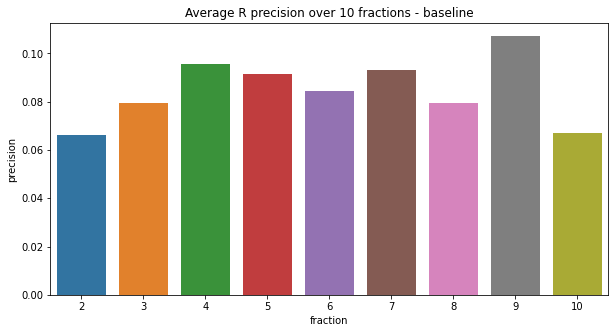

In [52]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(result_mean.keys()), y=list(result_mean.values()))

_ = ax.set_title('Average R precision over 10 fractions - baseline')

ax.set_ylabel('precision')
ax.set_xlabel('fraction')

plt.savefig('../../images/baseline_average_R_precision.png', bbox_inches = 'tight')

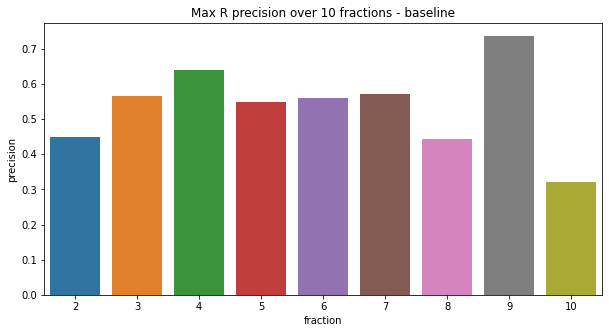

In [53]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(result_max.keys()), y=list(result_max.values()))

_ = ax.set_title('Max R precision over 10 fractions - baseline')

ax.set_ylabel('precision')
ax.set_xlabel('fraction')

plt.savefig('../../images/baseline_max_R_precision.png', bbox_inches = 'tight')

In [54]:
result = []

for keys in result_mean:
  result.append({'mean' : result_mean[keys]})

i = 0
for keys in result_max:
  result[i]['max'] = result_max[keys]
  result[i]['fraction'] = i + 2
  i = i + 1

result

[{'fraction': 2, 'max': 0.4482758620689655, 'mean': 0.06616075873035011},
 {'fraction': 3, 'max': 0.5671641791044776, 'mean': 0.07950141050080699},
 {'fraction': 4, 'max': 0.6388888888888888, 'mean': 0.09546368664402469},
 {'fraction': 5, 'max': 0.55, 'mean': 0.09131664096027141},
 {'fraction': 6, 'max': 0.5595238095238095, 'mean': 0.08445638600583248},
 {'fraction': 7, 'max': 0.5714285714285714, 'mean': 0.09316476168213825},
 {'fraction': 8, 'max': 0.4431818181818182, 'mean': 0.07936101201933339},
 {'fraction': 9, 'max': 0.7368421052631579, 'mean': 0.10721971142893588},
 {'fraction': 10, 'max': 0.32222222222222224, 'mean': 0.0669425499296408}]

In [56]:
df_result = pd.DataFrame(result)
df_result.to_csv('baseline_result.csv', index = False)

**Nhận xét**: 

Tuy chỉ là baseline nhưng kết quả **Average R precision** trên các fraction khác nhau thu được cũng khá khả quan, dao động từ 0.06 - 0.1, tức là đoán đúng được 6% - 10% phần còn lại của playlist.

Ngoài ra kết quả sử dụng nhiều features tốt hơn nhiều so với chỉ sử dụng một feature là 'danceability' - chỉ đề xuất đúng được trung bình 1-2%.